# Latent Dirichlet Allocation (Gibbs Sampling algorithm)

Code blocks below are adapted from _Data Science from Scratch_ by Joel Grus (2015).

In [2]:
import math, random, re
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
from bs4 import BeautifulSoup
import requests
import pandas as pd
from scipy.stats import ttest_ind

### Gibbs Sampling

The code below illustrates the Gibbs Sampling algorithm, a popular method used to optimize LDA topic models. Although this is a simplified example, the `gibbs_sample` function is meant to be analogous to sampling from the conditional probability distributions of words in topics and topics in documents. The `compare_distributions` and the bar chart below help us to compare the results of these two ways of sampling random 'die rolls'. The results converge towards the same uniform distribution as more samples are taken. 

Read the following section from [Grus (246-7)](https://ebookcentral.proquest.com/lib/canterbury/reader.action?docID=2025407).

In [3]:
def roll_a_die():
    return random.choice([1,2,3,4,5,6])

def direct_sample():
    d1 = roll_a_die()
    d2 = roll_a_die()
    return d1, d1 + d2

def random_y_given_x(x):
    """equally likely to be x + 1, x + 2, ... , x + 6"""
    return x + roll_a_die()

def random_x_given_y(y):
    if y <= 7:
        # if the total is 7 or less, the first die is equally likely to be
        # 1, 2, ..., (total - 1)
        return random.randrange(1, y)
    else:
        # if the total is 7 or more, the first die is equally likely to be
        # (total - 6), (total - 5), ..., 6
        return random.randrange(y - 6, 7)

def gibbs_sample(num_iters=100):
    x, y = 3, 4 # doesn't matter what values you start with
    for _ in range(num_iters):
        x = random_x_given_y(y)
        y = random_y_given_x(x)
    return x, y

def compare_distributions(num_samples=1000):
    counts = defaultdict(lambda: [0, 0])
    for _ in range(num_samples):
        counts[gibbs_sample()][0] += 1
        counts[direct_sample()][1] += 1
    return counts

In [4]:
# try these functions
roll_a_die()

5

In [5]:
direct_sample()

(6, 9)

In [6]:
# Create a pandas dataframe and plot of our sampling comparison
df = pd.DataFrame(compare_distributions(num_samples=5000))

In [7]:
# transpose rows to cols and name the cols
df2 = df.T
df2.columns = ['Gibbs sample', 'Direct sample']

<AxesSubplot:>

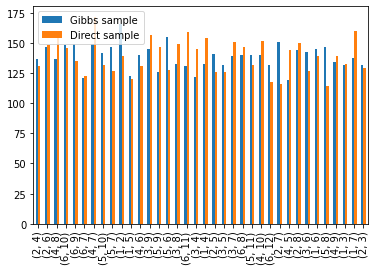

In [8]:
# make a bar chart
df2.plot.bar()
# Increase the number of samples in the compare_distributions function and re-plot
# You should see we get the same kind of distribution either way

### LDA Topic model

Please refer to [Grus (247-252)](https://ebookcentral.proquest.com/lib/canterbury/reader.action?docID=2025407) and run the code below as you do.

In [9]:
def sample_from(weights):
    total = sum(weights)
    rnd = total * random.random()       # uniform between 0 and total
    for i, w in enumerate(weights):
        rnd -= w                        # return the smallest i such that
        if rnd <= 0: return i           # sum(weights[:(i+1)]) >= rnd

documents = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]


K = 4

document_topic_counts = [Counter()
                         for _ in documents]

topic_word_counts = [Counter() for _ in range(K)]

topic_counts = [0 for _ in range(K)]

document_lengths = [len(d) for d in documents]

distinct_words = set(word for document in documents for word in document)
W = len(distinct_words)

D = len(documents)

def p_topic_given_document(topic, d, alpha=0.1):
    """the fraction of words in document _d_
    that are assigned to _topic_ (plus some smoothing)"""

    return ((document_topic_counts[d][topic] + alpha) /
            (document_lengths[d] + K * alpha))

def p_word_given_topic(word, topic, beta=0.1):
    """the fraction of words assigned to _topic_
    that equal _word_ (plus some smoothing)"""

    return ((topic_word_counts[topic][word] + beta) /
            (topic_counts[topic] + W * beta))

def topic_weight(d, word, k):
    """given a document and a word in that document,
    return the weight for the k-th topic"""

    return p_word_given_topic(word, k) * p_topic_given_document(k, d)

def choose_new_topic(d, word):
    return sample_from([topic_weight(d, word, k)
                        for k in range(K)])


random.seed(0)
document_topics = [[random.randrange(K) for word in document]
                   for document in documents]

for d in range(D):
    for word, topic in zip(documents[d], document_topics[d]):
        document_topic_counts[d][topic] += 1
        topic_word_counts[topic][word] += 1
        topic_counts[topic] += 1

for iter in range(1000):
    for d in range(D):
        for i, (word, topic) in enumerate(zip(documents[d],
                                              document_topics[d])):

            # remove this word / topic from the counts
            # so that it doesn't influence the weights
            document_topic_counts[d][topic] -= 1
            topic_word_counts[topic][word] -= 1
            topic_counts[topic] -= 1
            document_lengths[d] -= 1

            # choose a new topic based on the weights
            new_topic = choose_new_topic(d, word)
            document_topics[d][i] = new_topic

            # and now add it back to the counts
            document_topic_counts[d][new_topic] += 1
            topic_word_counts[new_topic][word] += 1
            topic_counts[new_topic] += 1
            document_lengths[d] += 1

In [10]:
# topic MODELING

for k, word_counts in enumerate(topic_word_counts):
    for word, count in word_counts.most_common():
        if count > 0: print(k, word, count)

topic_names = ["Big Data and programming languages",
                "databases",
                "machine learning",
                "statistics"]

for document, topic_counts in zip(documents, document_topic_counts):
    print(document)
    for topic, count in topic_counts.most_common():
        if count > 0:
            print(topic_names[topic], count)
    print()

0 Java 3
0 Big Data 3
0 Hadoop 2
0 HBase 1
0 C++ 1
0 Spark 1
0 Storm 1
0 programming languages 1
0 MapReduce 1
0 Cassandra 1
0 deep learning 1
1 HBase 2
1 neural networks 2
1 Postgres 2
1 MongoDB 2
1 machine learning 2
1 Cassandra 1
1 numpy 1
1 decision trees 1
1 deep learning 1
1 databases 1
1 MySQL 1
1 NoSQL 1
1 artificial intelligence 1
1 scipy 1
2 regression 3
2 Python 2
2 R 2
2 libsvm 2
2 scikit-learn 2
2 mathematics 1
2 support vector machines 1
2 Haskell 1
2 Mahout 1
3 statistics 3
3 probability 3
3 Python 2
3 R 2
3 pandas 2
3 statsmodels 2
3 C++ 1
3 artificial intelligence 1
3 theory 1
['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra']
Big Data and programming languages 7

['NoSQL', 'MongoDB', 'Cassandra', 'HBase', 'Postgres']
databases 5

['Python', 'scikit-learn', 'scipy', 'numpy', 'statsmodels', 'pandas']
databases 2
machine learning 2
statistics 2

['R', 'Python', 'statistics', 'regression', 'probability']
statistics 3
machine learning 2

['machine learn

### Videos to follow up with

For a further visual explanation, watch Louis Serrano's videos on LDA and the Gibbs sampling algorithm (highly recommended):

- Part 1: https://www.youtube.com/watch?v=T05t-SqKArY
- Part 2: https://www.youtube.com/watch?v=BaM1uiCpj_E